# Using synthetic data, test `xclim` QDM with a "rolling" future CDF

For each future year, select the surrounding `n` years to compute the inverse CDF and only return the given year's bias corrected output. This makes use of an update to our fork of `xclim`

March 2021



In [1]:
! pip install git+https://github.com/ClimateImpactLab/xclim.git@qdm_add_year_selection
# pip install -e /home/jovyan/xclim 

  Cloning https://github.com/ClimateImpactLab/xclim.git (to revision qdm_add_year_selection) to /tmp/pip-req-build-gp1cone1


In [2]:
%matplotlib inline
import xarray as xr
import scipy as sp
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 

In [3]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

In [4]:
write_direc = '../figures/' #'/gcs/rhg-data/climate/downscaled/workdir'

In [5]:
import xclim
from xclim import sdba

## QDM 

I messed with my local copy of `xclim` so there might be print messages. 

In [6]:
from scipy.stats import scoreatpercentile
from scipy.stats.kde import gaussian_kde

from xclim.testing.tests.test_sdba import utils as tu

## Synth data with `kind="+"` instead of "*"

Now we will test additive variables and other things

copied and adapted functions from ....`xclim/xclim/testing/tests/test_sdba/utils.py` 

#### Note
The following analyses and validation test on a single grid cell. 



In [7]:
# these funcs modified from ~/xclim/xclim/testing/tests/test_sdba/utils.py

# TODO add these funcs to a utils script or something, since they are now in two notebooks: synthetic_test_xclim_qdm.ipynb and this one
def my_series(values, name, start="2000-01-01"):
    import collections

    
    coords = collections.OrderedDict()
    for dim, n in zip(("time", "lon", "lat"), values.shape):
        if dim == "time":
            coords[dim] = pd.date_range(start, periods=n, freq=pd.DateOffset(days=1))
        else:
            coords[dim] = xr.IndexVariable(dim, np.arange(n))

    if name == "tas":
        attrs = {
            "standard_name": "air_temperature",
            "cell_methods": "time: mean within days",
            "units": "K",
            "kind": "+",
        }
    elif name == "pr":
        attrs = {
            "standard_name": "precipitation_flux",
            "cell_methods": "time: sum over day",
            "units": "kg m-2 s-1",
            "kind": "*",
        }

    return xr.DataArray(
        values,
        coords=coords,
        dims=list(coords.keys()),
        name=name,
        attrs=attrs,
    )

def my_dist():
    from scipy.stats import norm

    # ref ~ gamma(k=4, theta=7.5)  mu: 30, sigma: 15
    ref = norm(4, scale=7.5)

    # hist ~ gamma(k=8.15, theta=3.68) mu: 30, sigma: 10.5
    hist = norm(8.15, scale=3.68)

    # sim ~ gamma(k=16, theta=2.63) mu: 42, sigma: 10.5
    sim = norm(16, scale=2.63)

    return ref, hist, sim


def my_rvs(n, kind='+', random=True):
    # Frozen distributions
    if kind=='*':
        return tu.cannon_2015_rvs(n, random=random)
    else:
        fd = my_dist()

        if random:
            r = [d.rvs(n) for d in fd]
        else:
            raise NotImplementedError
    #         u = equally_spaced_nodes(n, None)
    #         r = [d.ppf(u) for d in fd]

        return map(lambda x: my_series(x, "tas"), r)

def add_annual_cycle(ds):
    annual_cycle = np.sin(2 * np.pi * (ds.time.dt.dayofyear.values / 365.25 - 0.28)) 
    return (ds + 10*annual_cycle)

def add_simple_trend(ds, totalchange=20):
    trend = np.linspace(0,totalchange,len(ds.time))
    return ds + trend

In [76]:
random = True
n = 40000
nquantiles = 50 #620 is empirical
kind = "+" #"*" #"+"

if kind=='*':
    kindstr='mult'
else:
    kindstr='add'

ref, hist, sim = my_rvs(n, kind, random=random)


### Day Grouping

This notebook has been tested with `window=31` as well. It runs smoothly, but notes haven't been updated to reflect results with a group that includes a window, in part because leap days haven't been removed and results will be sensitive to that.

TODO:
- Notebook needs to be updated to have leap days removed and calendar updated to "noleap".

In [77]:
# add a simple future trend and annual cycle

ref = add_annual_cycle(ref)
hist = add_annual_cycle(hist)
sim = add_annual_cycle(sim)

simtrend = add_simple_trend(sim, totalchange=20)
simtrend = add_annual_cycle(simtrend)

In [78]:
def remove_leap_days(da):
    noleap = da.where(~((da.time.dt.month == 2) & 
                        (da.time.dt.day == 29)), drop=True)
    
    years = np.arange(da.time.dt.year.min(),da.time.dt.year.max()+1)
    if len(da.time) == len(np.arange(1,366))*len(years):
        noleap = noleap.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(years)).flatten(),
                                                dims=('time'),
                                                coords={'time':noleap.time})).persist()
    else:
        # adjust years to leave off last (not-full) year
        years = np.arange(da.time.dt.year.min(),da.time.dt.year.max())
        # create full year time array
        time_array = np.array([np.arange(1,366)]*len(years))
        # creat datenum for last year (if first year, change to min)
        last_yr = [np.arange(1,len(da['time'].sel(time=str(da.time.dt.year.max().values)))+1)]*1
        # combine to one new time array
        all_time = np.append(time_array, last_yr)
        
        noleap = noleap.assign_coords(dayofyear=xr.DataArray(all_time.flatten(),
                                                dims=('time'),
                                                coords={'time':noleap.time})).persist()
        
    return noleap

In [79]:
ref = remove_leap_days(ref)
hist = remove_leap_days(hist)
sim = remove_leap_days(sim)
simtrend = remove_leap_days(simtrend)

In [80]:
grouper = "time.dayofyear"
window = 91 

grouper = sdba.Grouper(grouper, window=window)

QMdg = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QMdg.train(ref, hist) #(ref, hist)  

DQMdg = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
DQMdg.train(ref, hist)

QDMdg = sdba.adjustment.QuantileDeltaMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QDMdg.train(ref, hist)

In [81]:
hist_qdm = QDMdg.adjust(hist)
sim_qdm = QDMdg.adjust(sim)
simtrend_qdm = QDMdg.adjust(simtrend)

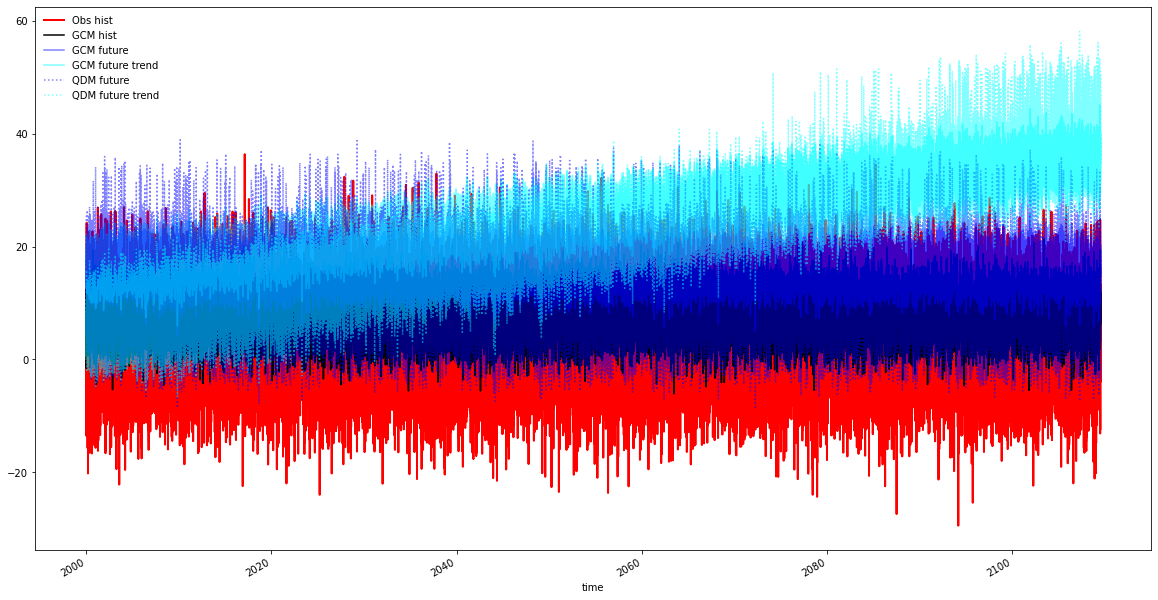

In [82]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ref.plot(ax=ax, linewidth=2, color="r", label="Obs hist")
hist.plot(ax=ax, color="k", label="GCM hist")
sim.plot(ax=ax, color="blue", label="GCM future", alpha=.5)
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
sim_qdm.plot(ax=ax, linestyle=':', color="blue", label="QDM future", alpha=.5)
simtrend_qdm.plot(ax=ax, linestyle=':', color="cyan", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

Text(0.5, 1.0, 'QDM Grouped on time.dayofyear + window 91')

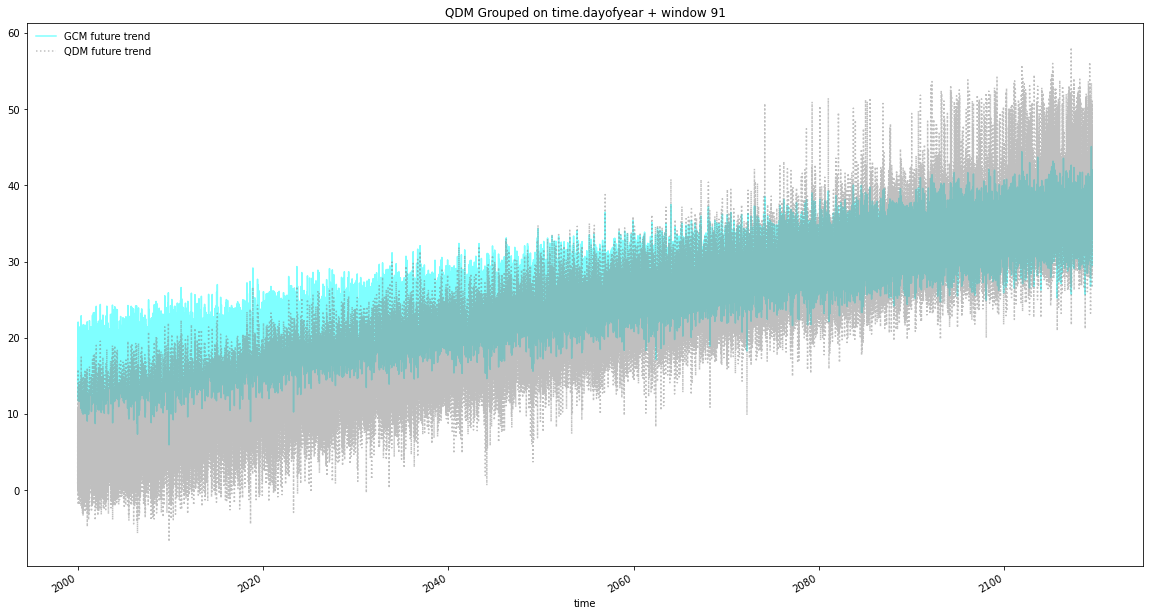

In [83]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
simtrend_qdm.plot(ax=ax, linestyle=':', color="gray", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)
ax.set_title('QDM Grouped on {} + window {}'.format(QDMdg.group.name, QDMdg.group.window))

In [69]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*n) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*n) # total change

print('\n  simtrend  ', sp.stats.linregress(np.arange(len(simtrend.time)), simtrend.values).slope*n)
print('  QDM simtrend', sp.stats.linregress(np.arange(len(simtrend_qdm.time)), simtrend_qdm.values).slope*n)

all days linear trend
  sim     -0.08198216942051383
  QDM sim -0.223195958615914

  simtrend   19.94050450058524
  QDM simtrend 33.86561229407658


### is the trend preserved?
In `simtrend` we're expecting to see the added trend of `totalchange` above (=20 currently). The uncorrected trend is pretty close to 20, but the default behavior of QDM (`QDM simtrend`) clearly changes that here, where we're just checking the linear trend through all days. The trend is much steeper after QDM and this is true for kind="*" and kind="+"

This outcome may not be applicable to our actual method, which is grouped by day and will have a rolling future cdf. SEE NEXT



# Rolling cdf

here we will loop through years in the future time series and call QDM with the `year` argument, concatenating the results

In [84]:
simy_qdm_list = []
simtrendy_qdm_list = []

roll = 10

# because we're rolling, we can't use the first and last 10 years
bc_years = np.arange(sim.time.dt.year.values[0]+roll,sim.time.dt.year.values[-1]-roll)

for yr in bc_years:
    
    timeslice = slice(str(yr-roll),str(yr+roll))
    
    # testing this on a future with a trend and one without
    simy_qdm_list.append(QDMdg.adjust(sim.sel(time=timeslice), year=yr)) 
    simtrendy_qdm_list.append(QDMdg.adjust(simtrend.sel(time=timeslice), year=yr)) 

simy_qdm = xr.concat(simy_qdm_list, dim='time')
simtrendy_qdm = xr.concat(simtrendy_qdm_list, dim='time')

Text(0.5, 1.0, 'QDM Grouped on time.dayofyear + window 91')

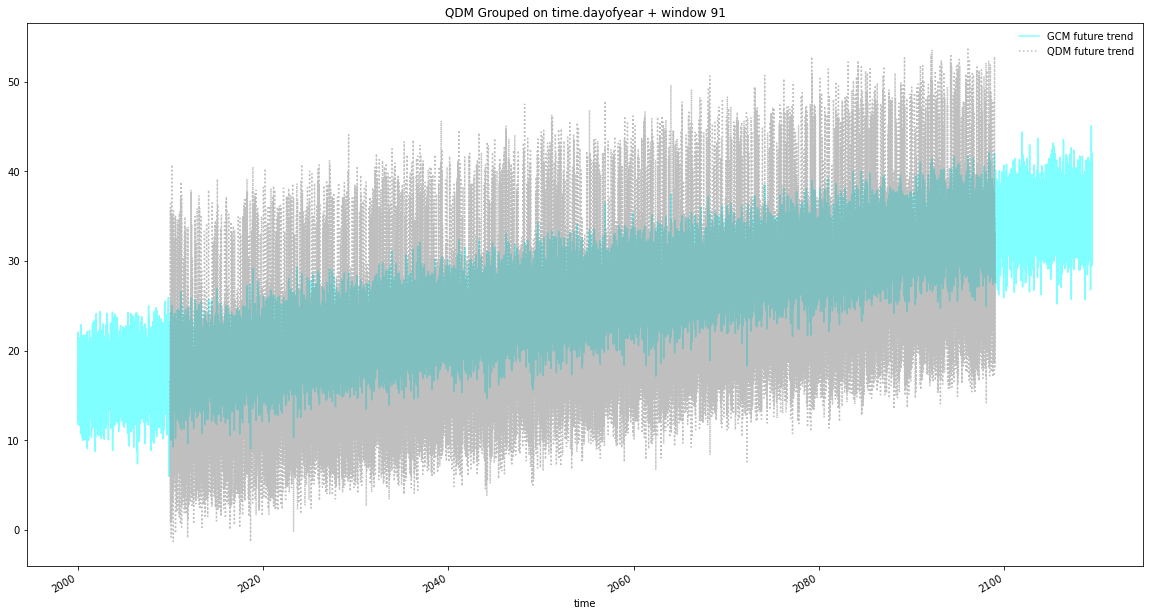

In [85]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
simtrendy_qdm.plot(ax=ax, linestyle=':', color="gray", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)
ax.set_title('QDM Grouped on {} + window {}'.format(QDMdg.group.name, QDMdg.group.window))

In [86]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*n) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*n) # total change

print('\n  simtrend                ', sp.stats.linregress(np.arange(len(simtrend.time)), simtrend.values).slope*n)
print('  QDM simtrend              ', sp.stats.linregress(np.arange(len(simtrend_qdm.time)), simtrend_qdm.values).slope*n)
print('  QDM simtrend with roll cdf', sp.stats.linregress(np.arange(len(simtrendy_qdm.time)), simtrendy_qdm.values).slope*n)


all days linear trend
  sim     -0.03944427694332999
  QDM sim -0.10754742566473385

  simtrend                 19.97451640129551
  QDM simtrend               32.083076976744024
  QDM simtrend with roll cdf 19.973364830635923


Awesome! Doing a bias correction on a rolling basis maintains the simple linear trend over the whole time series, unlike running QDM on the full time series at once.

### comparing quantiles - are the quantile trends preserved?

In [87]:
from plotting import quantile_compare_plot, compare_quantile_deltas_scatter_hist, compare_gcm_qdm_quantile_deltas

In [88]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim}
adjusted_dict = {'hist':hist_qdm,
                'sim':sim_qdm}
bcgrouper = QDMdg.group

In [19]:
QDMdg

QuantileDeltaMapping(nquantiles=50, kind='+', group=Grouper(dim='time', add_dims=['window'], prop='dayofyear', name='time.dayofyear', window=31, interp=False))

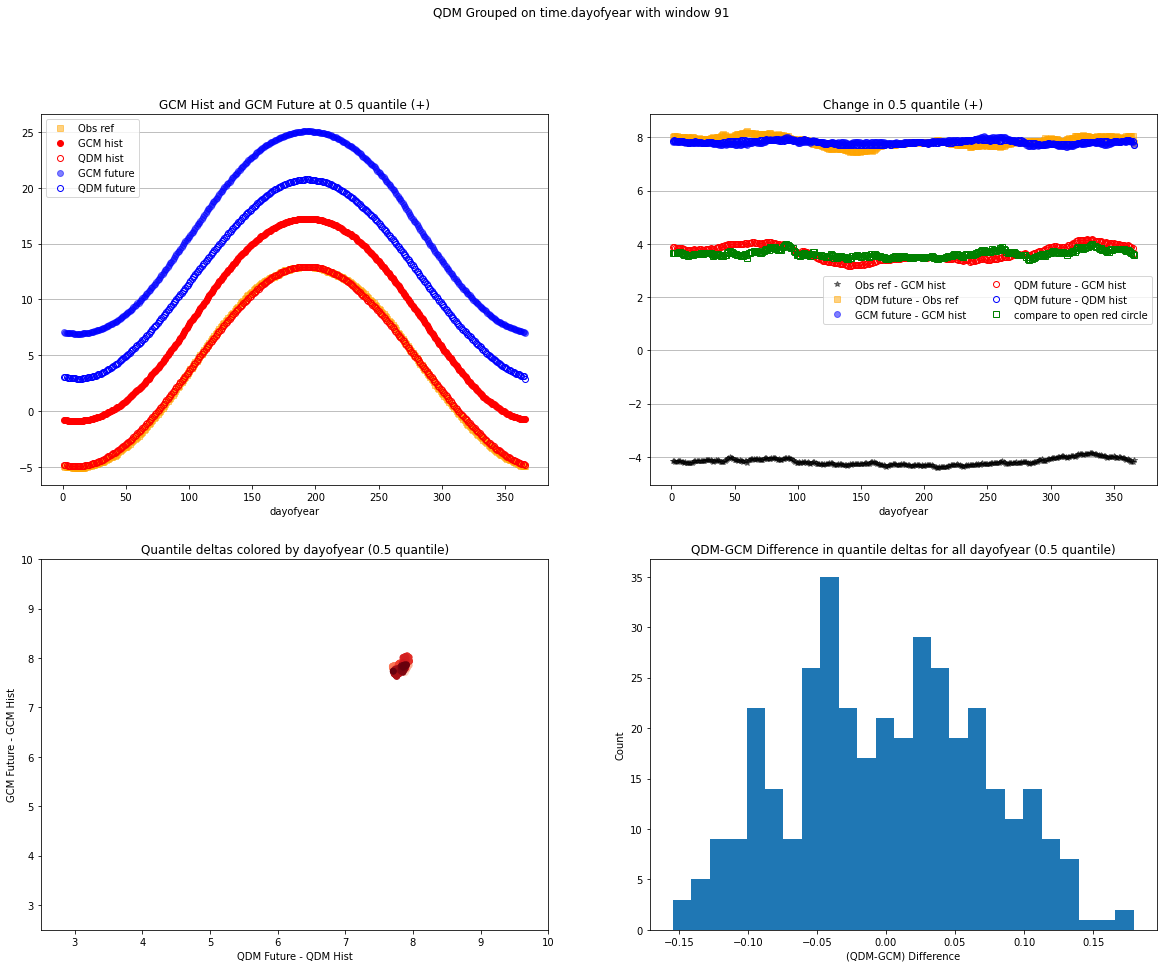

In [27]:
printtofile=False

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], tworow=True)

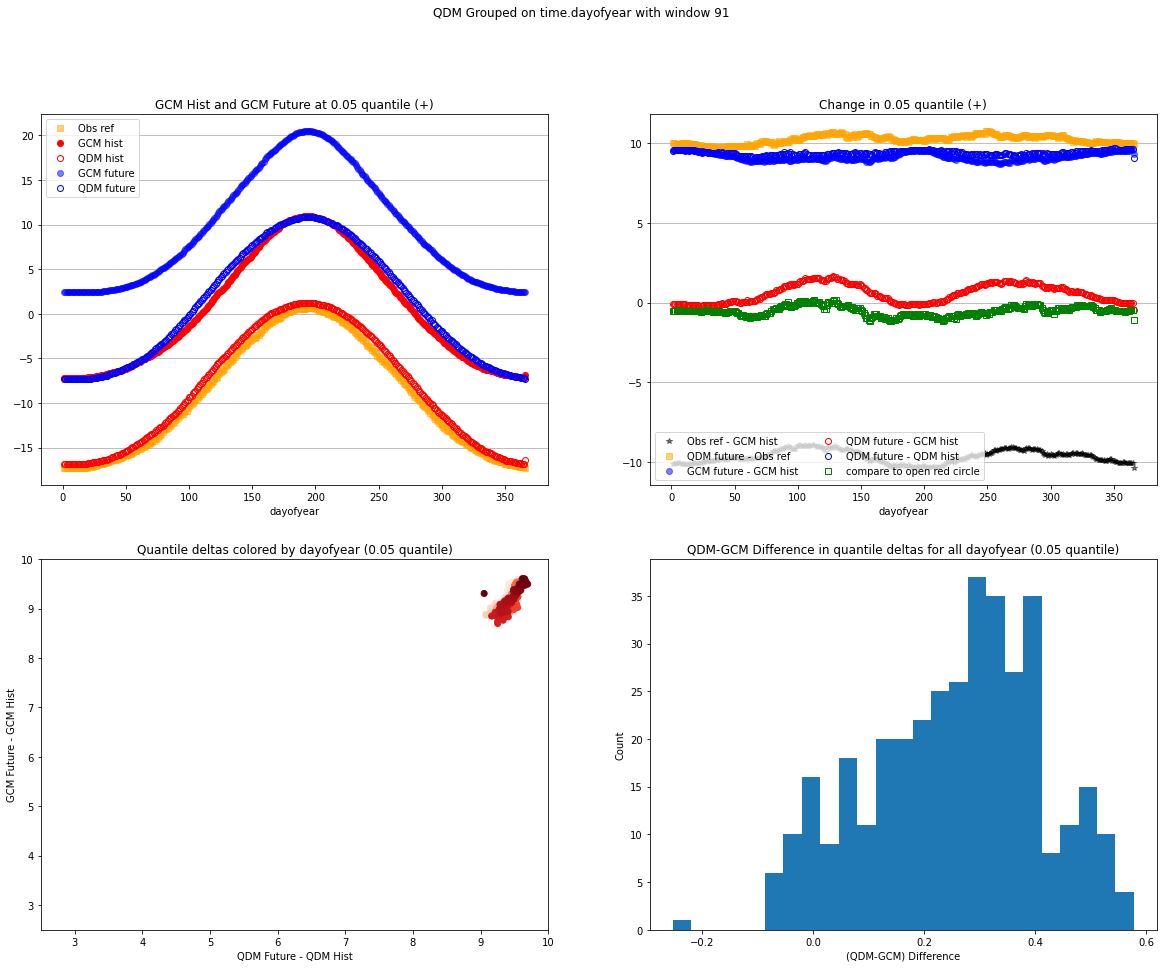

In [28]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.05], tworow=True)

setting simple=True will simplify the top right panel

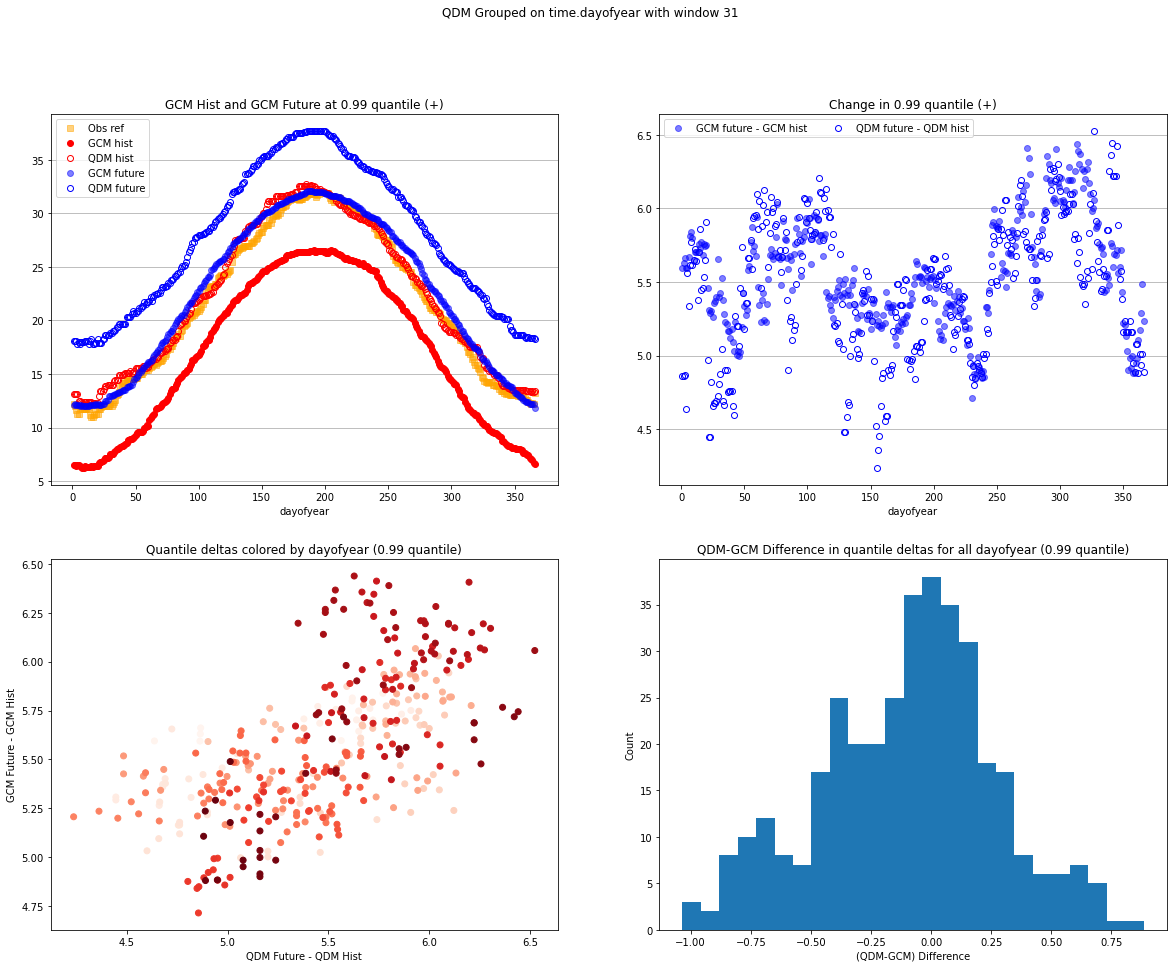

In [88]:
# 600 quantiles

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

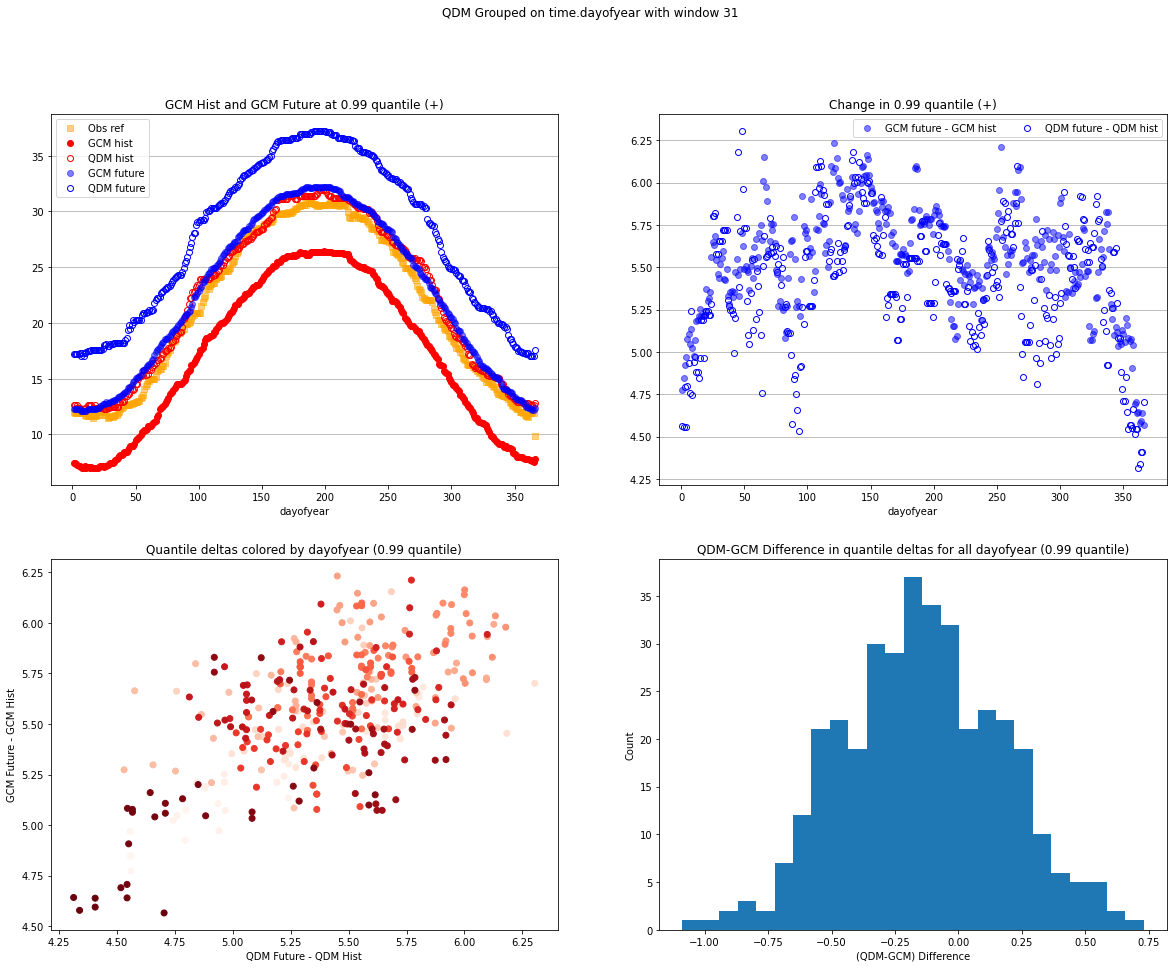

In [142]:
# 300 quantiles

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

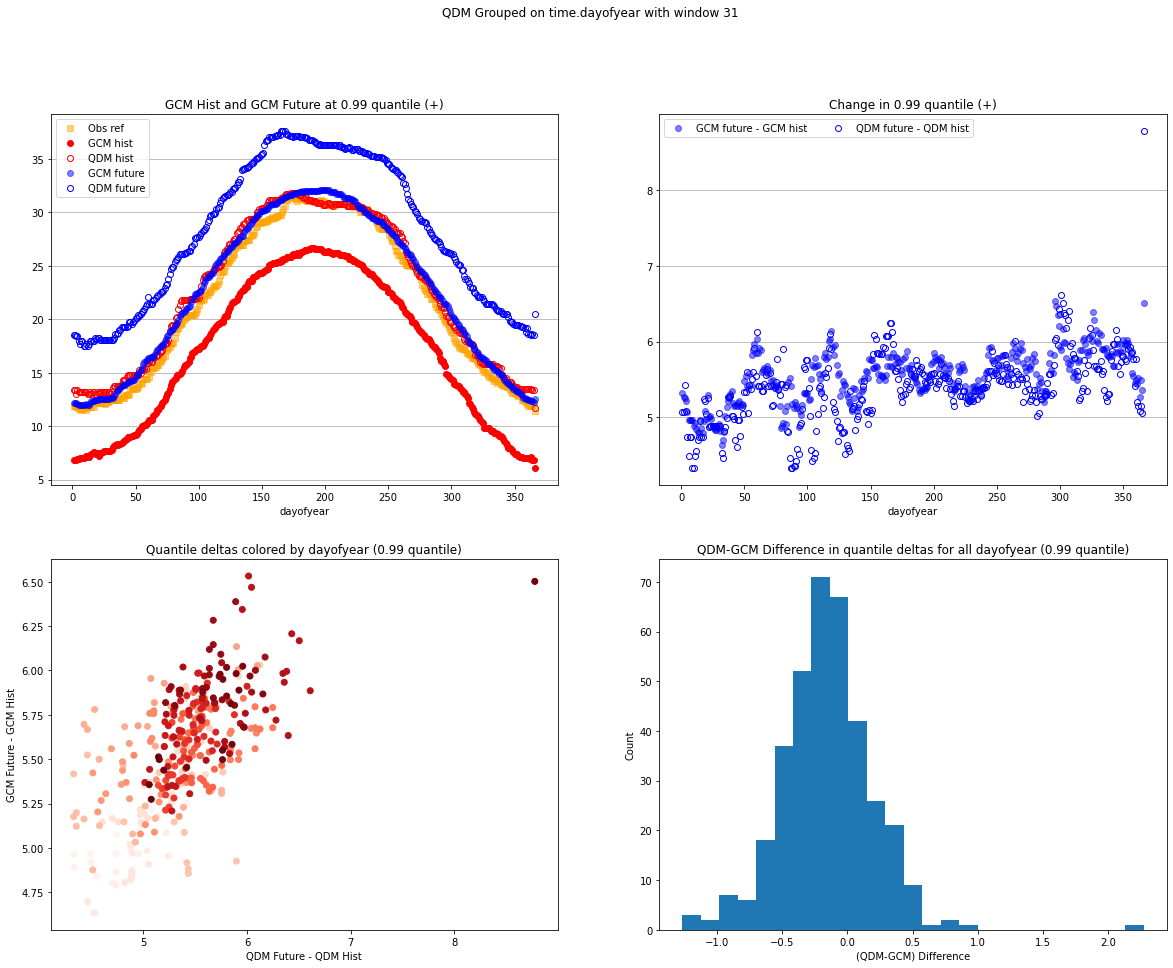

In [163]:
# 200 quantiles

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

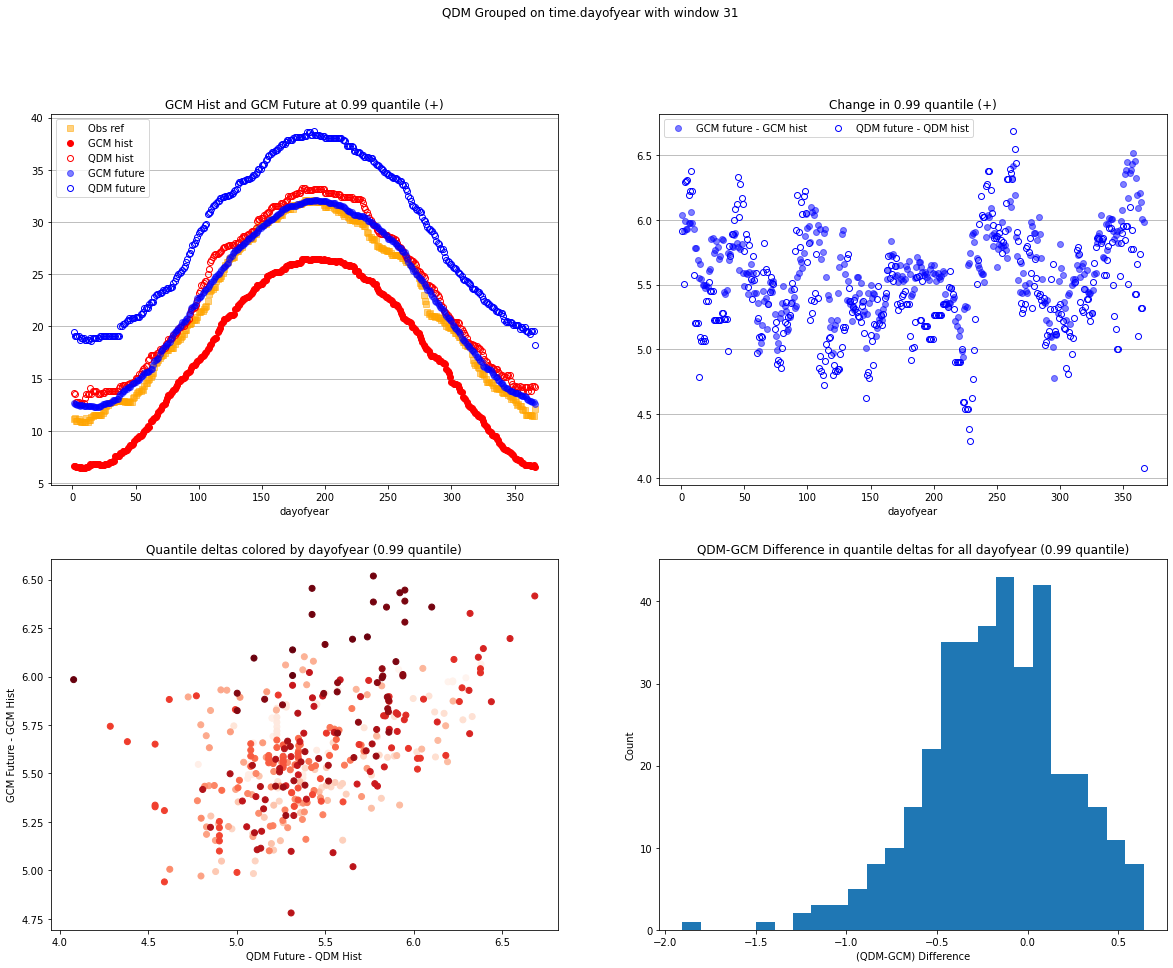

In [175]:
# 100 quantiles

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

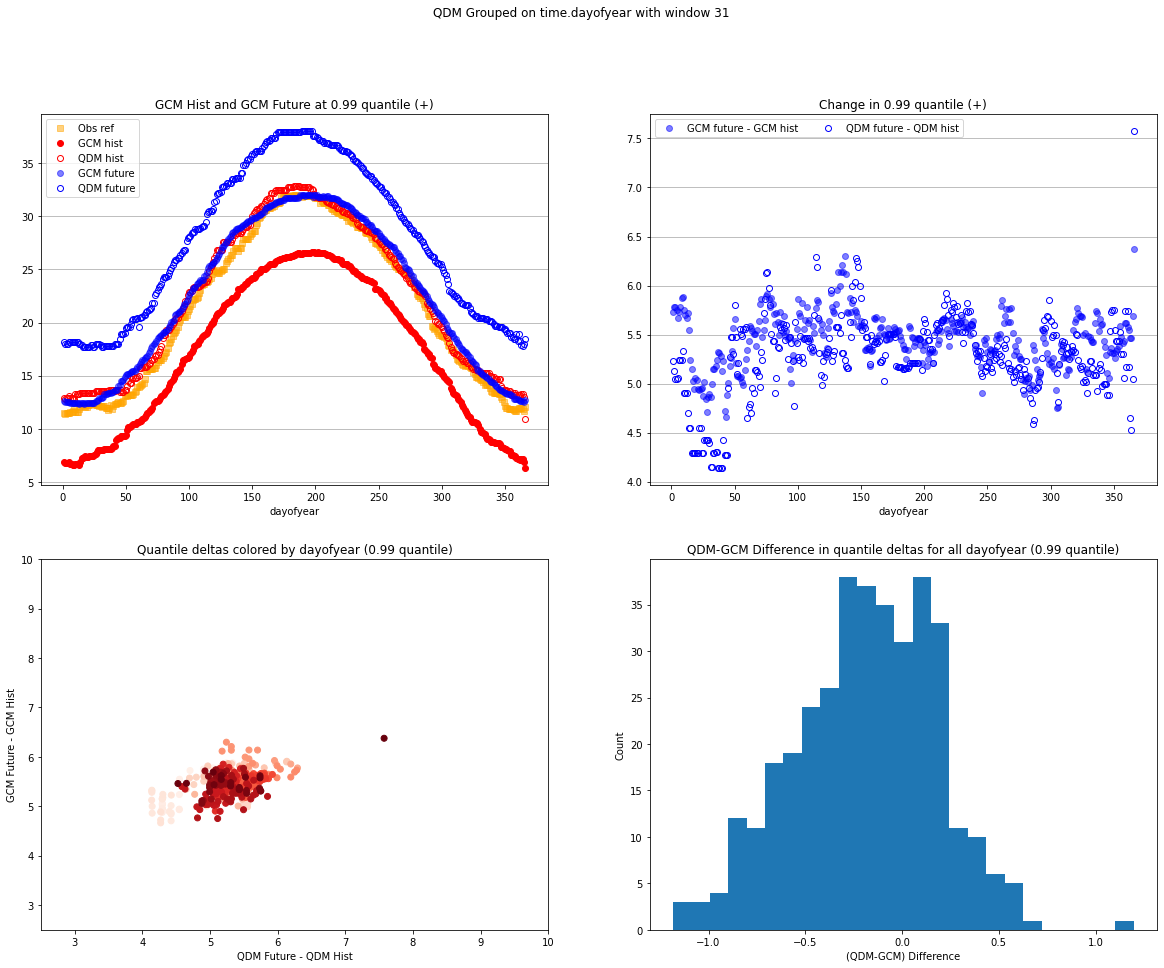

In [19]:
# 50 quantiles

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

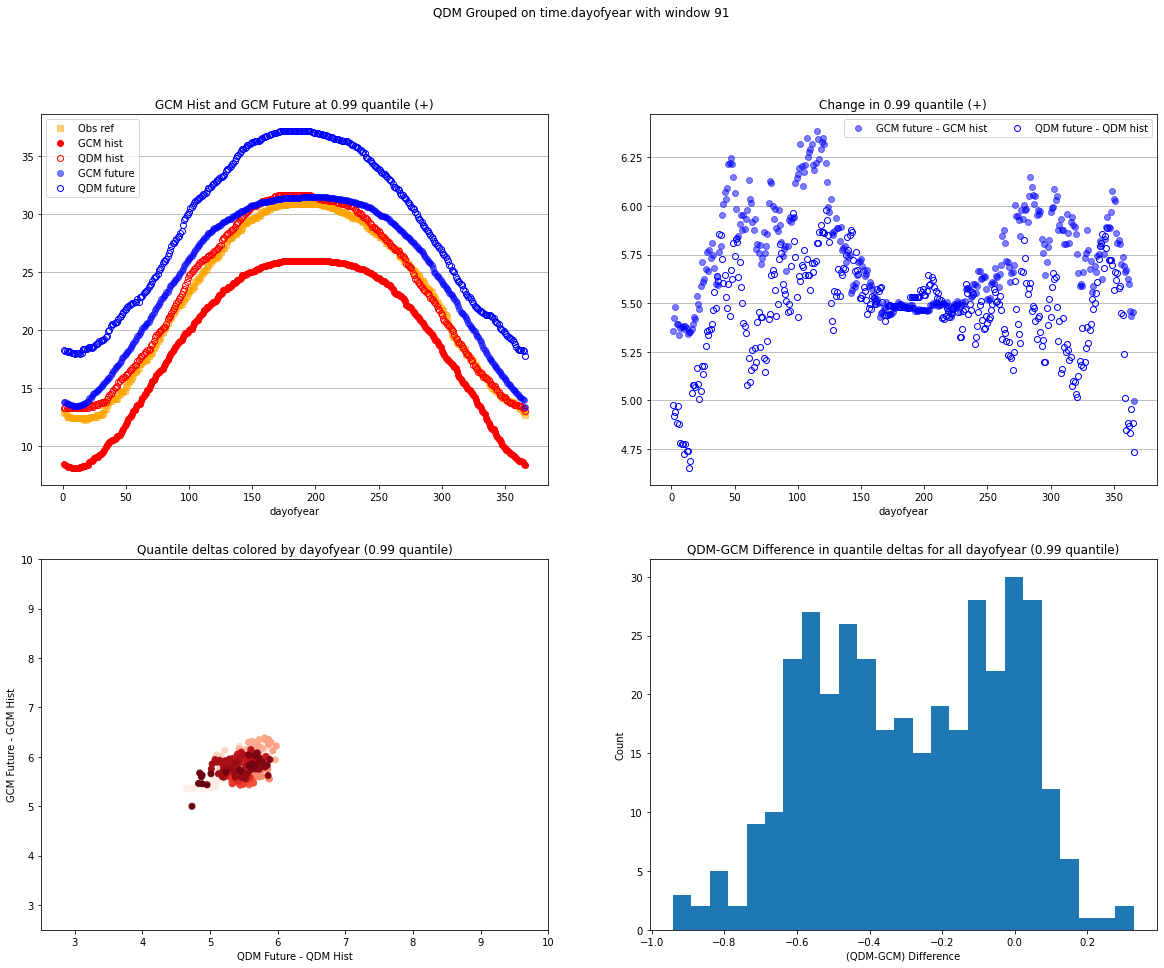

In [29]:
# 50 quantiles, 91 day window

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

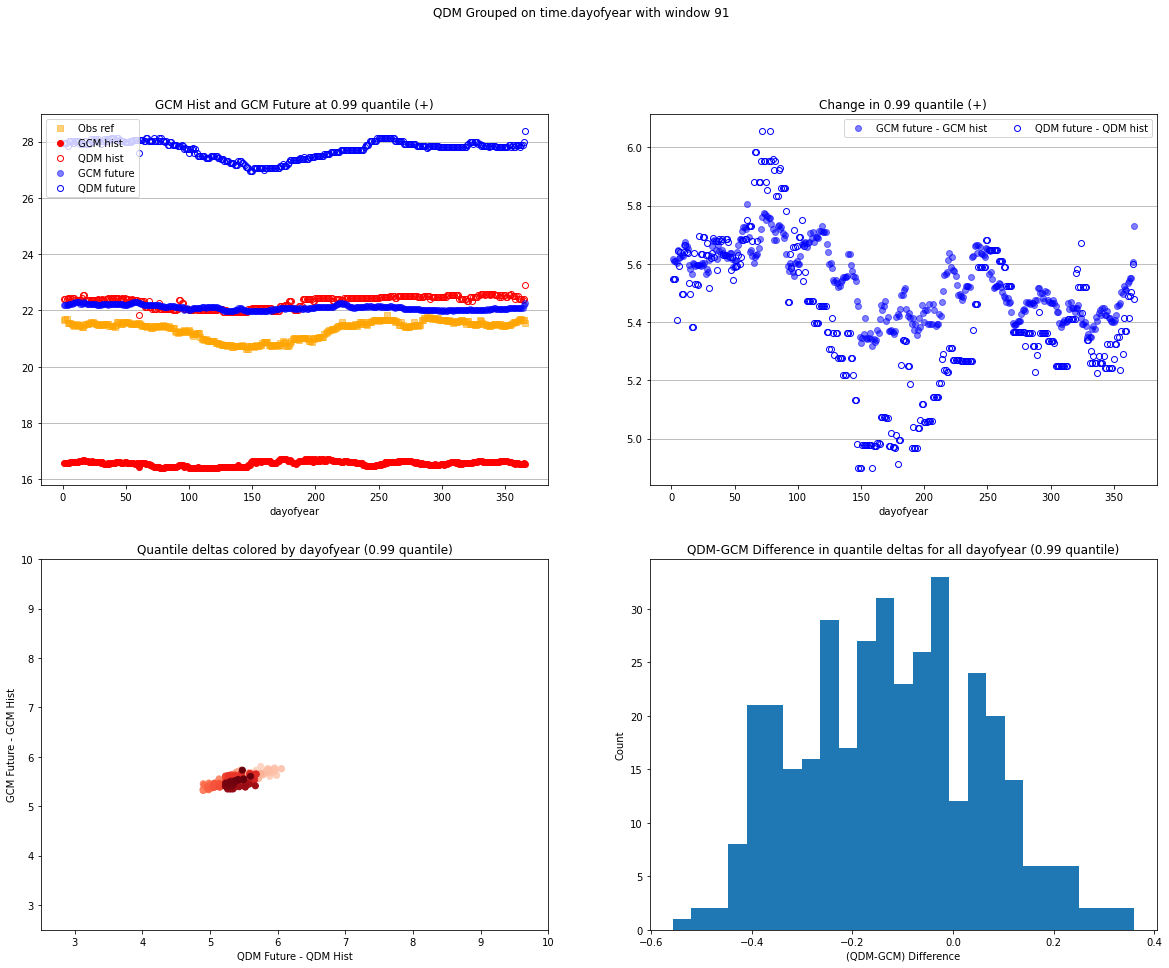

In [89]:
# 50 quantiles, 91 day window, no annual cycle

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

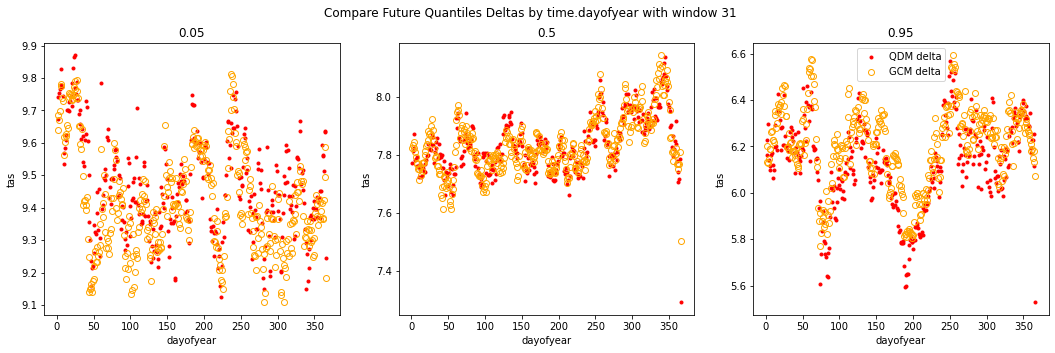

In [212]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

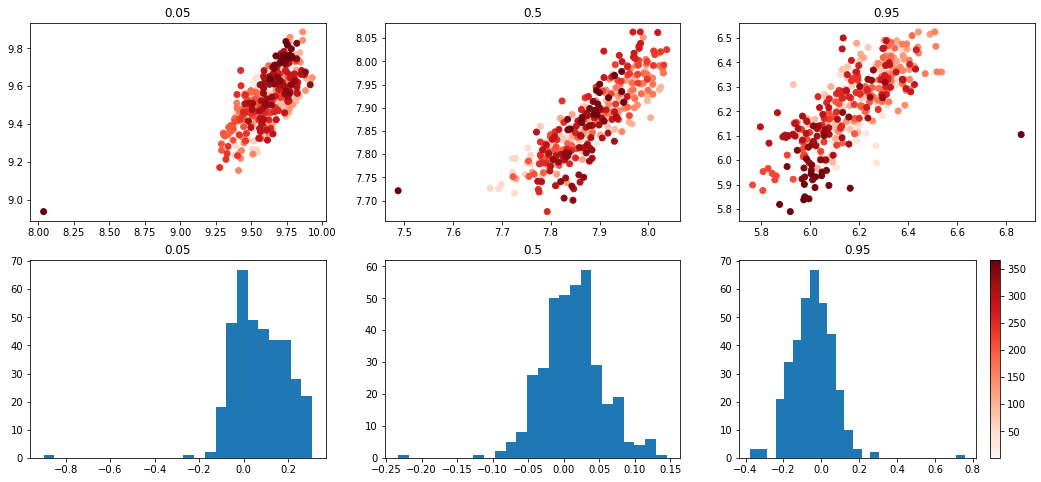

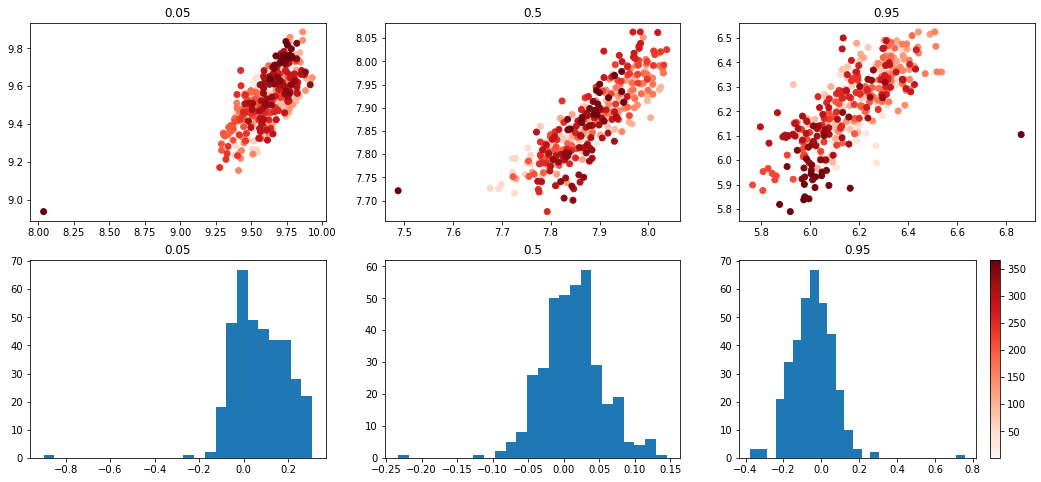

In [120]:
compare_quantile_deltas_scatter_hist(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

In general, it seems like quantile trends are *mostly* preserved, but not exactly, and they are more off near the tails (see the above histograms).

I'm not sure why these are off at all - some of it could certainly be leap days shifting things. But in `synthetic_test_xclim_qdm.ipynb` I tested the (non-rolling cdf) time series after removing leap years, and there were still differences. This needs testing here with rolling cdfs though. Try removing leap years and re-do the analysis.

Finally, note that there is no `window` here, so need to also re-do this analysis with `grouper="time.dayofyear"` and `window=31`

## TODO
- [X] Remove leap days to see if that improves the quantile comparisons
- [X] Test with a window of 31 days
- [ ] test a rolling object instead of looping through future years (this is low prio, since the current implementation jives well with how we will use argo to submit jobs on azure). But, can we do something like:

```
simrolling = simtrend.rolling(center=True, time=21*365) # or whatever the correct syntax is (also would need to remove leap days for this to work)
simrolling.apply(QDMdg.adjust()) # or it might be: simrolling.reduce(QDMdg.adjust())
```

In [123]:
# How do the raw timeseries change in time? 

mean_hist = hist.mean().compute()
mean_sim = sim.mean().compute()

mean_diff = mean_sim - mean_hist
mean_diff

<xarray.DataArray 'tas' ()>
array(7.86604543)

In [124]:
# How do the bias corrected timeseries change in time? 

mean_histqdm = hist_qdm.mean().compute()
mean_simqdm = sim_qdm.mean().compute()

mean_qdm_diff = mean_simqdm - mean_histqdm
mean_qdm_diff

<xarray.DataArray ()>
array(7.86604543)

In [139]:
# calculate trends in time across day of year
years = np.unique(hist.time.dt.year)

# calc the trend of each day across years
z = np.polyfit(years, hist.groupby('dayofyear'), 1)
p = np.poly1d(z)

TypeError: GroupBy objects only support binary ops when the other argument is a Dataset or DataArray

In [138]:
xr.DataArray(years)

<xarray.DataArray (dim_0: 110)>
array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
       2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043,
       2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054,
       2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065,
       2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076,
       2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098,
       2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109])
Dimensions without coordinates: dim_0

In [140]:
grouped_hist = hist.groupby('dayofyear').apply() -- check this, write a function with polyfit, then apply that function with polyfit to the groupby object
grouped_hist

DataArrayGroupBy, grouped over 'dayofyear' 
365 groups with labels 1, 2, 3, 4, 5, ..., 362, 363, 364, 365.

In [ ]:
pass the years into the function

In [274]:
test3 = hist.groupby('dayofyear').apply(calculate_trend)

AttributeError: 'tuple' object has no attribute 'dims'

In [98]:
def calculate_trend(da):
    # calc the trend of each day across years
    z = np.polyfit(years, da.values, 1)
    p = np.poly1d(z)
    
    return z

In [112]:
z = hist.groupby('dayofyear').map(calculate_trend)

AttributeError: 'numpy.ndarray' object has no attribute 'dims'

In [109]:
hist.polyfit(dim='time', deg=1)

<xarray.Dataset>
Dimensions:               (degree: 2)
Coordinates:
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree) float64 -6.475e-21 8.154

In [104]:
hist

<xarray.DataArray 'tas' (time: 39973)>
array([ 4.4577083 ,  6.74865592, 11.53747423, ...,  8.98907577,
        6.58993254, 12.13622423])
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2109-07-07
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 181 182 183 184 185 186 187 188
Attributes:
    standard_name:  air_temperature
    cell_methods:   time: mean within days
    units:          K
    kind:           +

In [31]:
# calculate trends in time across day of year
years = np.unique(hist.time.dt.year)

In [93]:
z = np.polyfit(years, groups[1], 1)
z

array([ 3.65e+02, -7.30e+05])

In [52]:
groups = hist.groupby('dayofyear').groups
groups[1]

[0,
 365,
 730,
 1095,
 1460,
 1825,
 2190,
 2555,
 2920,
 3285,
 3650,
 4015,
 4380,
 4745,
 5110,
 5475,
 5840,
 6205,
 6570,
 6935,
 7300,
 7665,
 8030,
 8395,
 8760,
 9125,
 9490,
 9855,
 10220,
 10585,
 10950,
 11315,
 11680,
 12045,
 12410,
 12775,
 13140,
 13505,
 13870,
 14235,
 14600,
 14965,
 15330,
 15695,
 16060,
 16425,
 16790,
 17155,
 17520,
 17885,
 18250,
 18615,
 18980,
 19345,
 19710,
 20075,
 20440,
 20805,
 21170,
 21535,
 21900,
 22265,
 22630,
 22995,
 23360,
 23725,
 24090,
 24455,
 24820,
 25185,
 25550,
 25915,
 26280,
 26645,
 27010,
 27375,
 27740,
 28105,
 28470,
 28835,
 29200,
 29565,
 29930,
 30295,
 30660,
 31025,
 31390,
 31755,
 32120,
 32485,
 32850,
 33215,
 33580,
 33945,
 34310,
 34675,
 35040,
 35405,
 35770,
 36135,
 36500,
 36865,
 37230,
 37595,
 37960,
 38325,
 38690,
 39055,
 39420,
 39785]

In [35]:
# calculate trends in time across day of year
years = np.unique(hist.time.dt.year)

# calc the trend of each day across years
z = np.polyfit(years, all_dates, 1)
p = np.poly1d(z)

In [37]:
p

poly1d([ 4.92245710e-03, -1.26469067e+01])

In [58]:
def group_calculate_trend(da):
    '''
    create function to create groups, loop through each day of grouping, calculate and save the trend (z,p)
    '''
    #pass da, create groups
    groups = da.groupby('dayofyear').groups
    
    z_dayofyear = []
    p_dayofyear = []

    # loop through dict groups for indices corresponding to each dayofyear
    for days in range(1,len(groups)):
        indices = groups[days]

        all_dates = []
        # loop through each index for all dayofyear instances 
        for date in range(0,len(indices)):
            da_alldates = da[indices[date]]
            all_dates.append(da_alldates)

        # turn list into DataArray -- becomes the array over which to calculate the trend
        all_dates = xr.DataArray(all_dates)

        # calculate trends in time across day of year
        years = np.unique(da.time.dt.year)
        
        # calc the trend of each day across years
        z = np.polyfit(years, all_dates, 1)
        p = np.poly1d(z)
        
        z_dayofyear.append(z)
        p_dayofyear.append(p)
        
    return [z_dayofyear, p_dayofyear]

In [59]:
[z,p] = group_calculate_trend(hist.sel(time=slice('2000-01-01','2108-12-31')))

In [ ]:
3.77357173e-03, -1.01290936e+01

In [118]:
p

[poly1d([ 3.77357173e-03, -1.01290936e+01]),
 poly1d([ 5.29843266e-03, -1.34123929e+01]),
 poly1d([ 8.37510513e-03, -1.86250257e+01]),
 poly1d([-3.46371417e-03,  5.34216461e+00]),
 poly1d([-4.24335815e-02,  8.47547907e+01]),
 poly1d([ 1.24435758e-02, -2.78665730e+01]),
 poly1d([ 1.63136157e-02, -3.57489790e+01]),
 poly1d([-1.77112789e-03,  1.81253336e+00]),
 poly1d([-2.10117005e-02,  4.07099830e+01]),
 poly1d([ 1.64248741e-03, -4.60913064e+00]),
 poly1d([ 5.02649458e-03, -1.18742629e+01]),
 poly1d([ 1.38359103e-02, -3.08172894e+01]),
 poly1d([-4.51725049e-03,  6.74874430e+00]),
 poly1d([-9.14246569e-03,  1.65612917e+01]),
 poly1d([-2.90969150e-03,  4.31866023e+00]),
 poly1d([ 1.40358758e-02, -3.04387518e+01]),
 poly1d([ 1.66430801e-02, -3.54463300e+01]),
 poly1d([-3.72060455e-03,  5.71916588e+00]),
 poly1d([-1.17658604e-02,  2.30180846e+01]),
 poly1d([-5.27086621e-03,  8.79134658e+00]),
 poly1d([-1.26473877e-02,  2.44275188e+01]),
 poly1d([-8.32641902e-03,  1.53666788e+01]),
 poly1d([ 

In [55]:
hist

<xarray.DataArray 'tas' (time: 39973)>
array([ 2.08439134, -4.94859775,  1.26647204, ..., 16.50433501,
       17.22448604, 19.55872731])
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2109-07-07
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 181 182 183 184 185 186 187 188

### comparing quantiles - are the quantile trends preserved?

In [36]:
from plotting import quantile_compare_plot, compare_quantile_deltas_scatter_hist, compare_gcm_qdm_quantile_deltas



In [37]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim}
adjusted_dict = {'hist':hist_qdm,
                'sim':sim_qdm}
bcgrouper = QDMdg.group

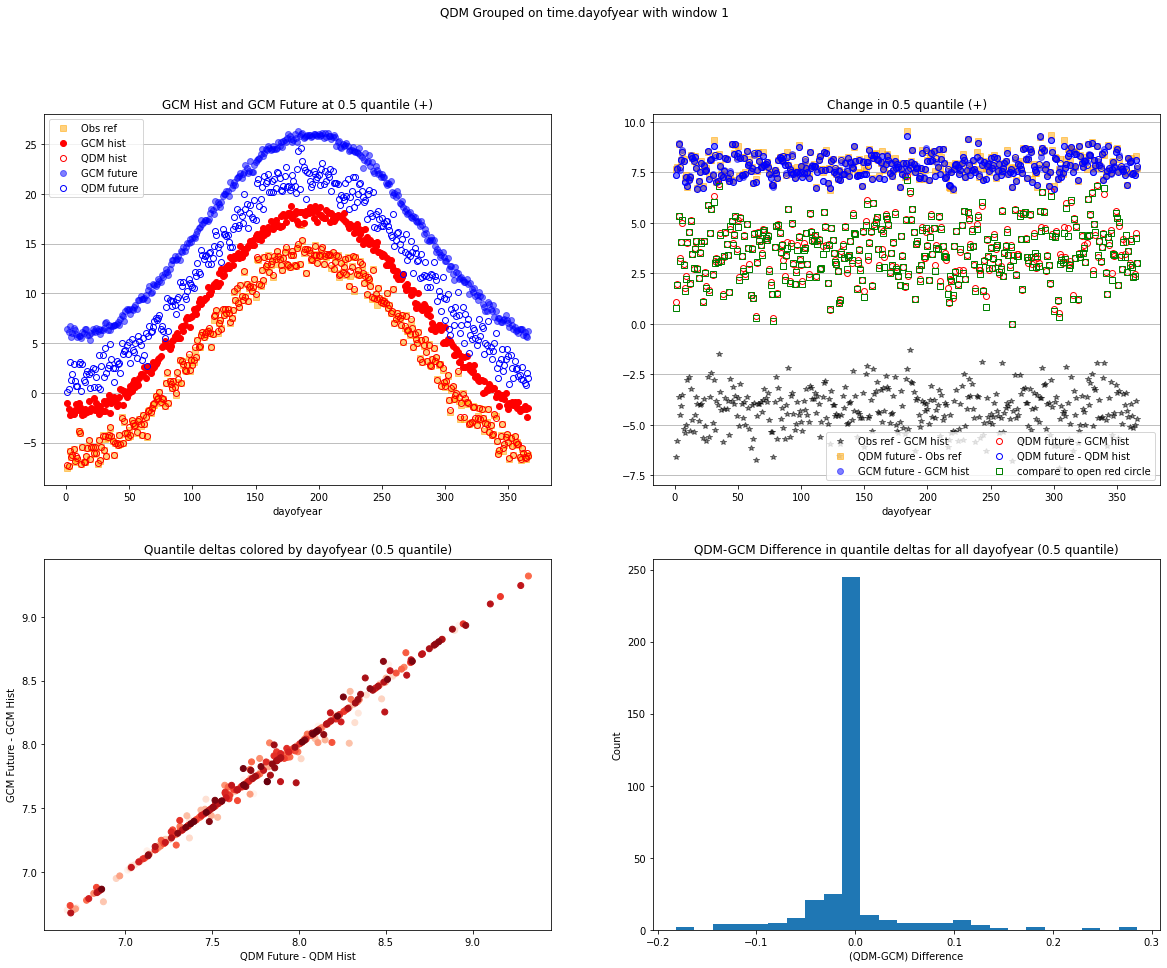

In [38]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
printtofile=False

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind,grouper=bcgrouper, quantiles=[.5], tworow=True)


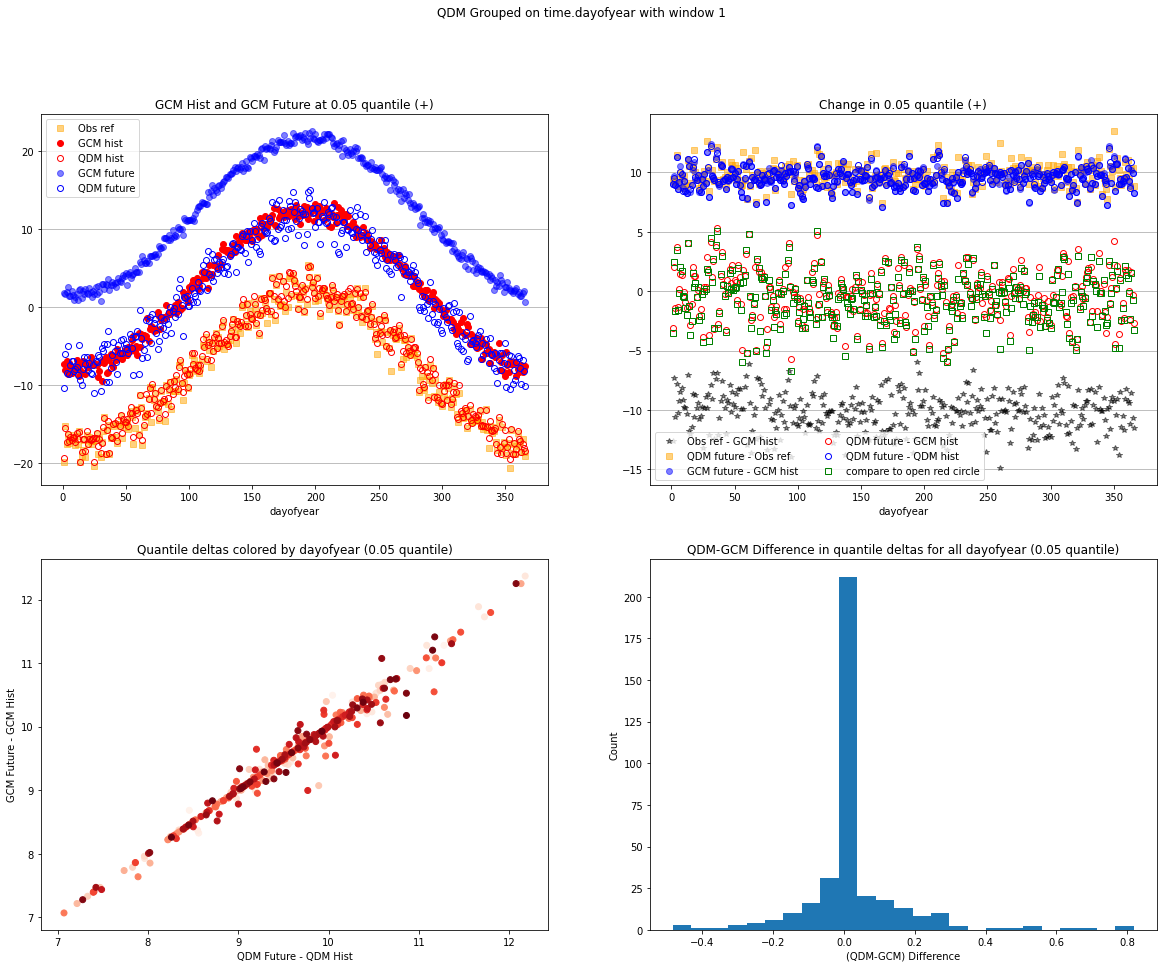

In [39]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind,grouper=bcgrouper, quantiles=[.05], tworow=True)


#### setting `simple=True` will simplify the top right panel

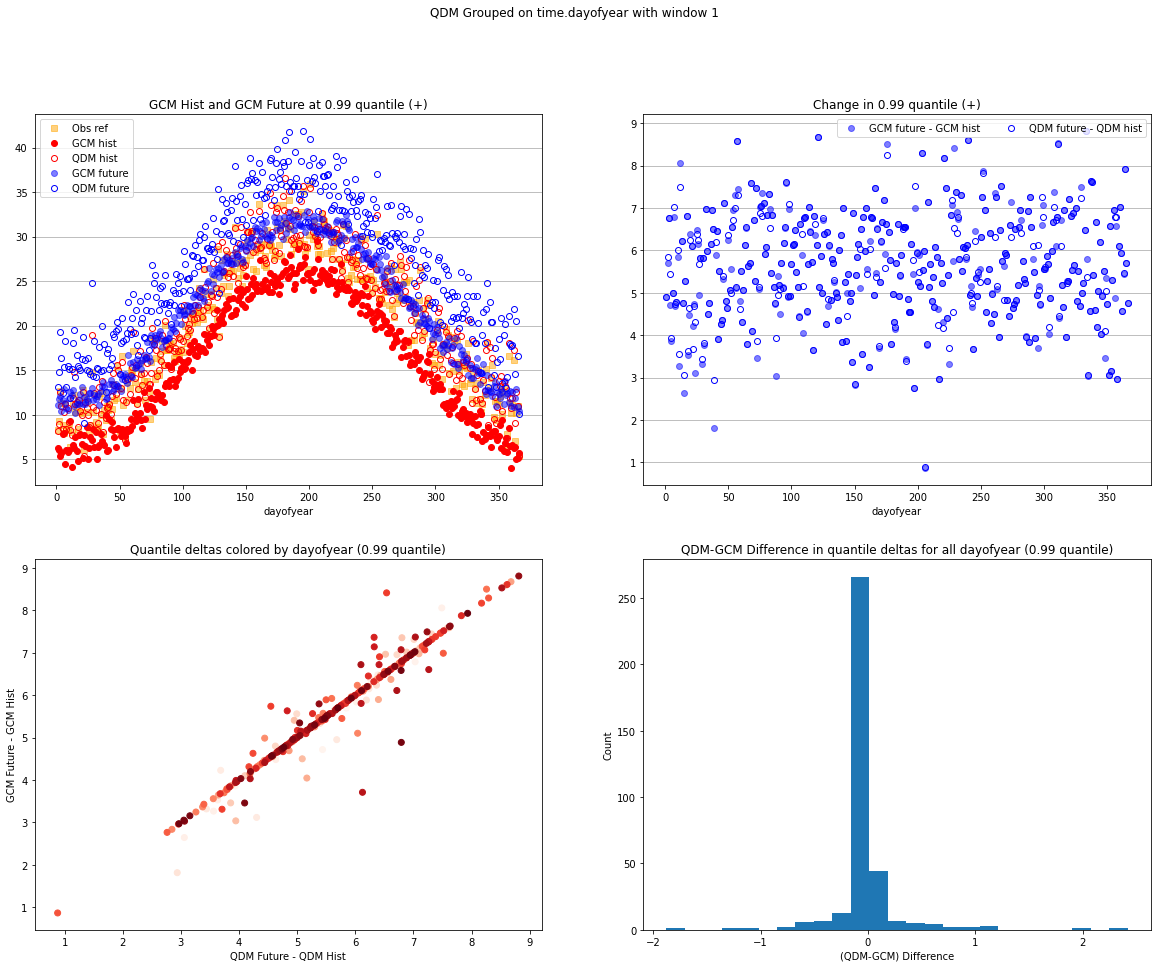

In [40]:
<<<<<<< LOCAL CELL DELETED >>>>>>>

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind,grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)


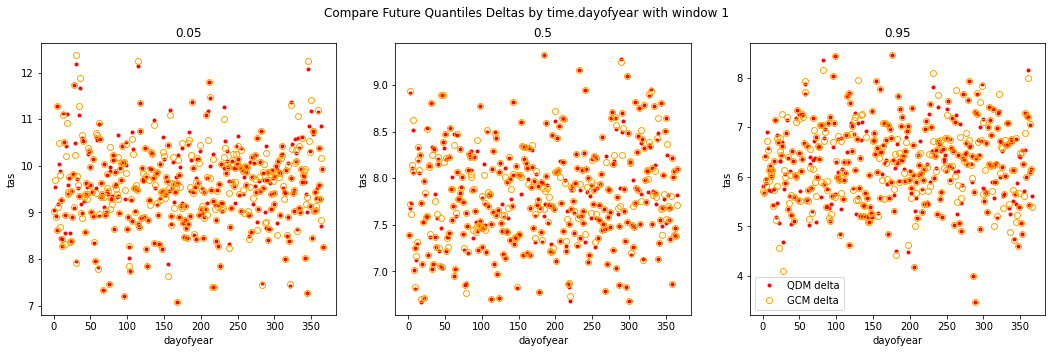

In [41]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict,adjusted_dict, kind=kind, grouper=bcgrouper)

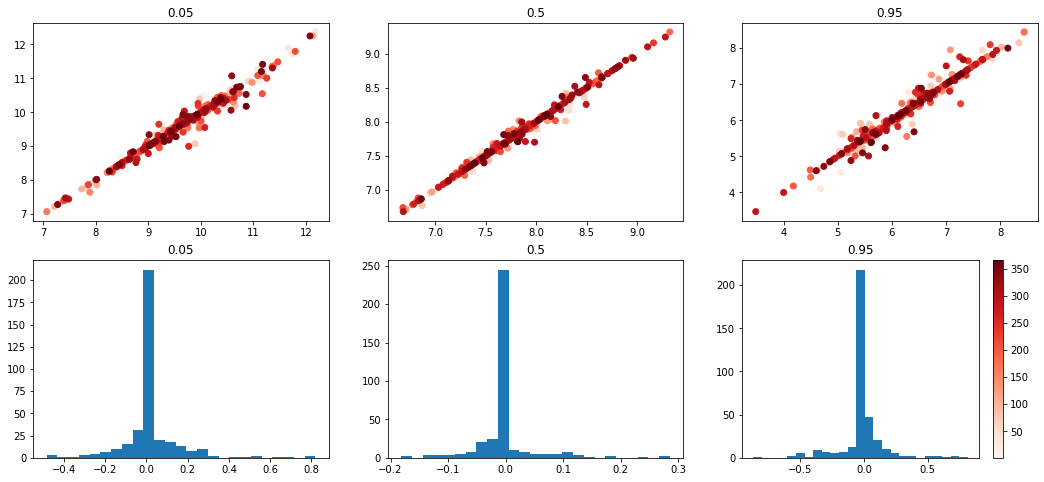

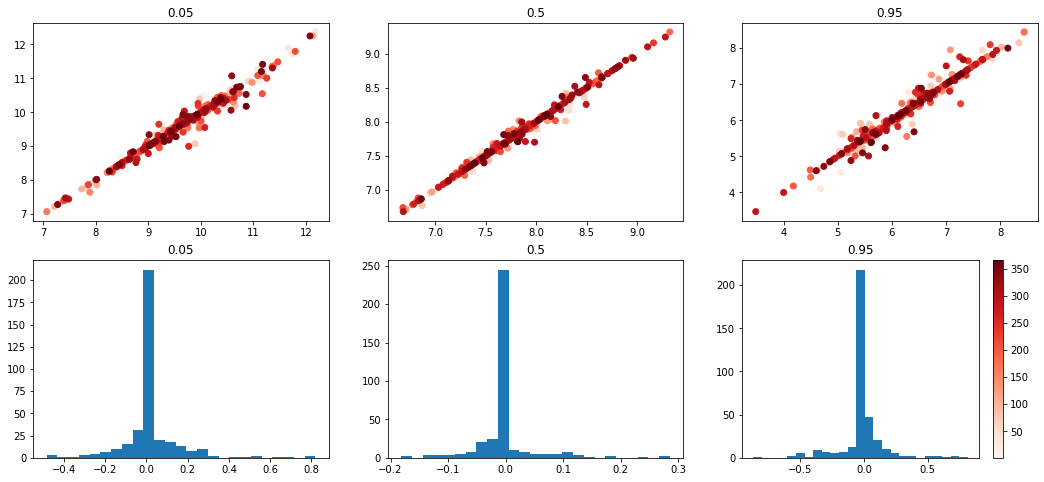

In [42]:
compare_quantile_deltas_scatter_hist(raw_dict,adjusted_dict, kind=kind, grouper=bcgrouper)

<<<<<<< LOCAL CELL DELETED >>>>>>>
In general, it seems like quantile trends are *mostly* preserved, but not exactly, and they are more off near the tails (see the above histograms).

I'm not sure why these are off at all - some of it could certainly be leap days shifting things. But in `synthetic_test_xclim_qdm.ipynb` I tested the (non-rolling cdf) time series after removing leap years, and there were still differences. This needs testing here with rolling cdfs though. Try removing leap years and re-do the analysis.

Finally, note that there is no `window` here, so need to also re-do this analysis with `grouper="time.dayofyear"` and `window=31`

## TODO
- [ ] Remove leap days to see if that improves the quantile comparisons
- [x] Test with a window of 31 days
- [ ] test a rolling object instead of looping through future years (this is low prio, since the current implementation jives well with how we will use argo to submit jobs on azure). But, can we do something like:

```
simrolling = simtrend.rolling(center=True, time=21*365) # or whatever the correct syntax is (also would need to remove leap days for this to work)
simrolling.apply(QDMdg.adjust()) # or it might be: simrolling.reduce(QDMdg.adjust())
```